In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import contextlib
import logging
import openbabel
from openbabel import pybel
import rdkit
import os
import sys

from random import randrange
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import rdFMCS, MolFromSmarts
from selfies import encoder, decoder 
from rdkit.Chem.Draw import MolToImage, IPythonConsole, rdMolDraw2D

import lomap

# Get the current working directory
current_dir = os.getcwd()

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

# Now you can import the module
from generator import fingerprint
from generator import generation
from generator import filters
from generator import scoring
from generator import visualization

In [ ]:
def find_mcs(smiles_1, smiles_2):
    """
    Find the maximum common substructure (MCS) of two molecules.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    rdkit.Chem.rdchem.Mol: The MCS of the two molecules.
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    template = Chem.MolFromSmarts(mcs.smartsString)

    return template

In [27]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

def find_mcs_and_rgroups_with_tags(smiles_1, smiles_2):
    """
    Find the maximum common substructure (MCS) of two molecules and return R-groups as separate SMILES, with
    tags for the positions where R-groups are connected to the MCS.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (MCS_SMILES_with_tags, Rgroups_smiles_1_with_tags, Rgroups_smiles_2_with_tags)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Create submolecules for R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)

    # Validate atom indices before tagging
    for idx in atoms_a:
        if idx < rgroup_a.GetNumAtoms():  # Ensure the index is within bounds
            rgroup_a.GetAtomWithIdx(idx).SetProp('atomNote', 'R_A')  # Tag R-group side in mol_a
    for idx in atoms_b:
        if idx < rgroup_b.GetNumAtoms():  # Ensure the index is within bounds
            rgroup_b.GetAtomWithIdx(idx).SetProp('atomNote', 'R_B')  # Tag R-group side in mol_b

    # Convert R-groups and MCS to SMILES (with tags)
    rgroup_smiles_1 = Chem.MolToSmiles(rgroup_a)
    rgroup_smiles_2 = Chem.MolToSmiles(rgroup_b)
    mcs_smiles = Chem.MolToSmiles(template)

    return mcs_smiles, rgroup_smiles_1, rgroup_smiles_2

In [90]:
liga_smiles = "O=C(Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1)c1ccccc1" #tyk2-43
ligb_smiles = "CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-44
num_tries = 2
num_random_smiles = 2
num_random_samples = 2
collect_bidirectional = True
exponent_path = 1
n_rounds = 1
fp_type = "ECFP4"

mcs, r1, r2 = find_mcs_and_rgroups_with_tags(liga_smiles, ligb_smiles)
print(mcs, r1, r2)
r1

O=CNC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1 cccccc.cn CC(C)(C)C


'cccccc.cn'

In [77]:
def get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    '''Obtain multiple paths/chemical paths from starting_smile to target_smile. 
    
    Parameters:
    starting_smile (string)     : SMILES string (needs to be a valid molecule)
    target_smile (int)          : SMILES string (needs to be a valid molecule)
    num_tries (int)             : Number of path/chemical path attempts between the exact same smiles
    num_random_samples (int)    : Number of different SMILES string orderings to consider for starting_smile & target_smile 
    collect_bidirectional (bool): If True, forms paths from target_smiles-> target_smiles (doubles the number of paths)
    fp_type (string)            : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 

    Returns:
    smiles_paths_dir1 (list): List of paths containing SMILES in the path between starting_smile -> target_smile
    smiles_paths_dir2 (list): List of paths containing SMILES in the path between target_smile -> starting_smile
    '''
    starting_smile_rand_ord = generation.get_random_smiles(starting_smile, num_random_samples=num_random_samples)
    target_smile_rand_ord = generation.get_random_smiles(target_smile, num_random_samples=num_random_samples)
    
    smiles_paths_dir1 = [] # All paths from starting_smile -> target_smile
    for smi_start in starting_smile_rand_ord: 
        for smi_target in target_smile_rand_ord: 
            
            if Chem.MolFromSmiles(smi_start) is None or Chem.MolFromSmiles(smi_target) is None: 
                raise Exception('Invalid structures')
                
            for _ in range(num_tries):
                path, _, _, _ = generation.obtain_path(smi_start, smi_target, filter_path=True, fp_type=fp_type)
                smiles_paths_dir1.append(path)
    
    smiles_paths_dir2 = [] # All paths from starting_smile -> target_smile
    if collect_bidirectional: 
        starting_smile_rand_ord = generation.get_random_smiles(target_smile, num_random_samples=num_random_samples)
        target_smile_rand_ord = generation.get_random_smiles(starting_smile, num_random_samples=num_random_samples)
        
        for smi_start in starting_smile_rand_ord: 
            for smi_target in target_smile_rand_ord: 
                
                if Chem.MolFromSmiles(smi_start) is None or Chem.MolFromSmiles(smi_target) is None: 
                    raise Exception('Invalid structures')
        
            for _ in range(num_tries):
                path, _, _, _ = generation.obtain_path(smi_start, smi_target, filter_path=True)
                smiles_paths_dir2.append(path)
                    
    return smiles_paths_dir1, smiles_paths_dir2


In [78]:
get_compr_paths(r1, r2, num_tries, num_random_samples, collect_bidirectional, fp_type)

EncoderError: failed to parse input
	SMILES: 

In [79]:

from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem

def find_mcs_and_tagged_rgroups(smiles_1, smiles_2):
    """
    Find the Maximum Common Substructure (MCS) and return the MCS with tags and the unique R-groups.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (MCS (rdkit Mol), R-groups from mol1, R-groups from mol2, mapped positions in mol1, mapped positions in mol2, match_a, match_b)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Create submolecules for the R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)
    
    # Map original atom indices to submolecule atom indices
    original_to_sub_a = {original: idx for idx, original in enumerate(atoms_a)}
    original_to_sub_b = {original: idx for idx, original in enumerate(atoms_b)}

    return template, rgroup_a, rgroup_b, original_to_sub_a, original_to_sub_b, match_a, match_b


def glue_rgroup_to_mcs_with_tags(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.
    
    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.
    
    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)
    
    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)
    
    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, rgroup_tag + mcs.GetNumAtoms(), order=Chem.BondType.SINGLE)
    
    # Get the final molecule
    final_molecule = editable_combined.GetMol()
    
    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)
    
    return final_molecule

def get_compr_paths_with_rgroup_gluing_and_tags(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    """
    Obtain multiple paths/chemical paths from starting_smile to target_smile, extract R-groups,
    glue them back onto the MCS using tagged positions, and print the resulting molecules.
    
    Parameters:
    starting_smile (string): SMILES string of the starting molecule.
    target_smile (string): SMILES string of the target molecule.
    num_tries (int): Number of path attempts.
    num_random_samples (int): Number of random samples to consider.
    collect_bidirectional (bool): If True, also form paths from target_smile to starting_smile.
    fp_type (string): Type of fingerprint.
    
    Returns:
    list: Unique reconstructed molecules (SMILES strings).
    """
    # Obtain paths (This uses your previous `get_compr_paths` function)
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type)
    
    # Combine the two lists of paths
    combined_paths = smiles_paths_dir1 + smiles_paths_dir2
    
    # Remove duplicates
    unique_paths = list(set(tuple(path) for path in combined_paths))
    
    # Find the MCS and extract R-groups along with the tagged positions and match arrays
    mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_tagged_rgroups(starting_smile, target_smile)
    
    # Reconstructed molecules
    reconstructed_molecules = []
    
    print("Gluing R-groups back onto the MCS at the correct positions:")
    
    # Attach R-group 1 to the MCS at the correct tagged position
    # Select the first valid key in map_a instead of assuming 0
    rgroup_1_idx = next(iter(map_a.keys()))  # Use the first key in map_a
    mol_with_rgroup_1 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_1, map_a[rgroup_1_idx], match_a[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_1))
    
    # Attach R-group 2 to the MCS at the correct tagged position
    rgroup_2_idx = next(iter(map_b.keys()))  # Use the first key in map_b
    mol_with_rgroup_2 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_2, map_b[rgroup_2_idx], match_b[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_2))
    
    # Print the reconstructed molecules
    for idx, molecule in enumerate(reconstructed_molecules):
        print(f"Reconstructed Molecule {idx+1}: {molecule}")
    
    return reconstructed_molecules




In [80]:
get_compr_paths_with_rgroup_gluing_and_tags(liga_smiles, ligb_smiles, num_tries, num_random_samples, collect_bidirectional, fp_type)

Gluing R-groups back onto the MCS at the correct positions:


StopIteration: 

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1076823/1919421708.py:37: SyntaxWarning: invalid escape sequence '\l'
  titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
/tmp/ipykernel_1076823/1919421708.py:37: SyntaxWarning: invalid escape sequence '\l'
  titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]


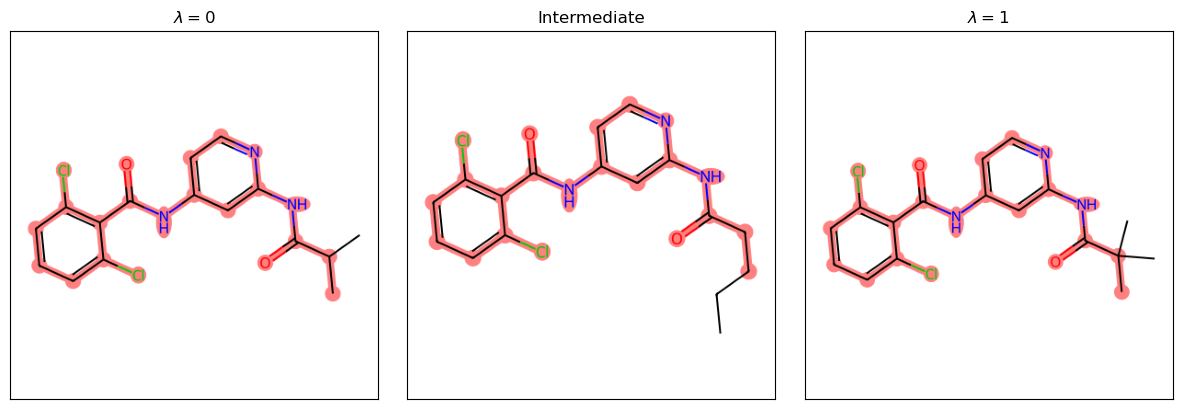

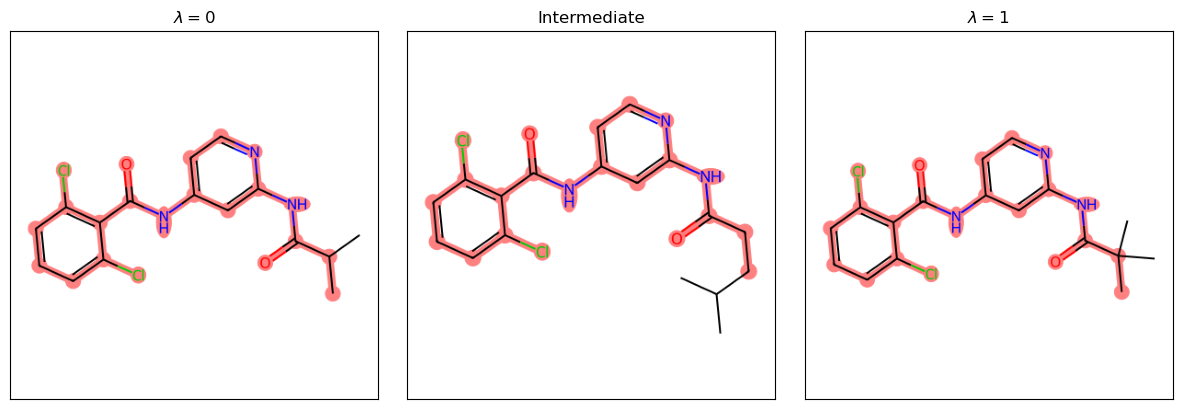

In [81]:
def visualise(liga_smiles, ligb_smiles, selected_intermediate_smiles):
    """
    Visualise and save an image of three aligned ligands with the Maximum Common Substructure (MCS) highlighted.
    
    Args:
        liga_smiles, ligb_smiles, selected_intermediate_smiles (str): The SMILES strings for the ligands to visualize.
        mins, secs (int): The minutes and seconds elapsed.
        filepath (str): The path to the location where the image is to be saved.
        filename (str): The name of the file.
    """
    # get intermediate
    liga = Chem.MolFromSmiles(liga_smiles)
    ligb = Chem.MolFromSmiles(ligb_smiles)
    intermediate = Chem.MolFromSmiles(selected_intermediate_smiles)

    # find MCS of the 3 molecules
    mcs_mol = filters.find_mcs_3_mols(liga_smiles, ligb_smiles, selected_intermediate_smiles)

    # Align ligands 
    molecules = visualization.alignLigands(liga, intermediate, ligb)

    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    # Generate the images with the MCS highlighted
    img0 = visualization.draw_molecule_with_mcs(liga, mcs_mol)
    img1 = visualization.draw_molecule_with_mcs(intermediate, mcs_mol)
    img2 = visualization.draw_molecule_with_mcs(ligb, mcs_mol)

    # Plot the images
    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)


    # Turn off axes and set titles.
    titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # set spacing between plots
    plt.subplots_adjust(wspace=0.08)



    plt.show()


visualise(liga_smiles, ligb_smiles, 'CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
visualise(liga_smiles, ligb_smiles, 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')

The code above is able to succesfully glue logical stuff back at the right location. however, the tag is probably wrong, since the glue position is not correct. 

In [82]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

def find_mcs_and_tagged_rgroups(smiles_1, smiles_2):
    """
    Find the Maximum Common Substructure (MCS) and return the MCS with tags and the unique R-groups.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (MCS (rdkit Mol), R-groups from mol1, R-groups from mol2, mapped positions in mol1, mapped positions in mol2, match_a, match_b)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    mcs_smiles = Chem.MolToSmiles(template)
    print("this is the smiles of the mcs:", mcs_smiles)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Create submolecules for the R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)

    # Map original atom indices to submolecule atom indices (renumbered)
    original_to_sub_a = {original: idx for idx, original in enumerate(atoms_a)}
    original_to_sub_b = {original: idx for idx, original in enumerate(atoms_b)}

    # We no longer need to tag atoms using the original indices, because the submolecules are renumbered.
    return template, rgroup_a, rgroup_b, original_to_sub_a, original_to_sub_b, match_a, match_b

def glue_rgroup_to_mcs_with_tags(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.
    
    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.
    
    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Print atom details for debugging
    print(f"Gluing R-group at atom {rgroup_tag} (element {rgroup.GetAtomWithIdx(rgroup_tag).GetSymbol()}) to MCS at atom {mcs_tag} (element {mcs.GetAtomWithIdx(mcs_tag).GetSymbol()})")
    
    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)
    
    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)
    
    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, rgroup_tag + mcs.GetNumAtoms(), order=Chem.BondType.SINGLE)
    
    # Get the final molecule
    final_molecule = editable_combined.GetMol()
    
    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)
    
    return final_molecule


def get_compr_paths_with_rgroup_gluing_and_tags(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    """
    Obtain multiple paths/chemical paths from starting_smile to target_smile, extract R-groups,
    glue them back onto the MCS using tagged positions, and print the resulting molecules.
    
    Parameters:
    starting_smile (string): SMILES string of the starting molecule.
    target_smile (string): SMILES string of the target molecule.
    num_tries (int): Number of path attempts.
    num_random_samples (int): Number of random samples to consider.
    collect_bidirectional (bool): If True, also form paths from target_smile to starting_smile.
    fp_type (string): Type of fingerprint.
    
    Returns:
    list: Unique reconstructed molecules (SMILES strings).
    """
    # Obtain paths (This uses your previous `get_compr_paths` function)
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type)
    
    # Combine the two lists of paths
    combined_paths = smiles_paths_dir1 + smiles_paths_dir2
    
    # Remove duplicates
    unique_paths = list(set(tuple(path) for path in combined_paths))
    
    # Find the MCS and extract R-groups along with the tagged positions and match arrays
    mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_tagged_rgroups(starting_smile, target_smile)
    
    # Print MCS and R-group atom indices for debugging
    print(f"match_a (MCS in mol_a): {match_a}")
    print(f"match_b (MCS in mol_b): {match_b}")
    print(f"map_a (R-group in mol_a): {map_a}")
    print(f"map_b (R-group in mol_b): {map_b}")
    
    # Reconstructed molecules
    reconstructed_molecules = []
    
    print("Gluing R-groups back onto the MCS at the correct positions:")
    
    # Attach R-group 1 to the MCS at the correct tagged position
    # Select the first valid key in map_a instead of assuming 0
    rgroup_1_idx = next(iter(map_a.keys()))  # Use the first key in map_a
    mol_with_rgroup_1 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_1, map_a[rgroup_1_idx], match_a[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_1))
    
    # Attach R-group 2 to the MCS at the correct tagged position
    rgroup_2_idx = next(iter(map_b.keys()))  # Use the first key in map_b
    mol_with_rgroup_2 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_2, map_b[rgroup_2_idx], match_b[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_2))
    
    # Print the reconstructed molecules
    for idx, molecule in enumerate(reconstructed_molecules):
        print(f"Reconstructed Molecule {idx+1}: {molecule}")
    
    return reconstructed_molecules


In [83]:
get_compr_paths_with_rgroup_gluing_and_tags(liga_smiles, ligb_smiles, num_tries, num_random_samples, collect_bidirectional, fp_type)

this is the smiles of the mcs: CC(C)C(=O)NC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1
match_a (MCS in mol_a): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
match_b (MCS in mol_b): (0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)
map_a (R-group in mol_a): {}
map_b (R-group in mol_b): {3: 0}
Gluing R-groups back onto the MCS at the correct positions:


StopIteration: 

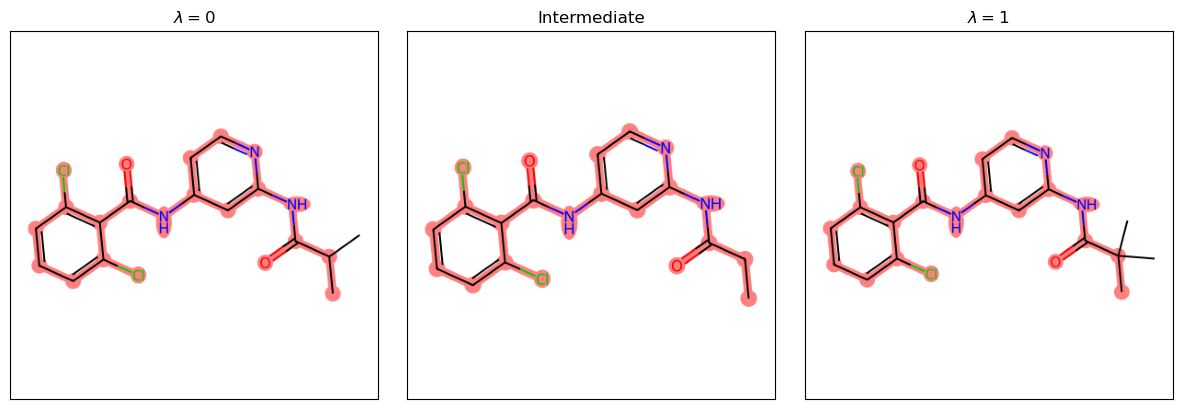

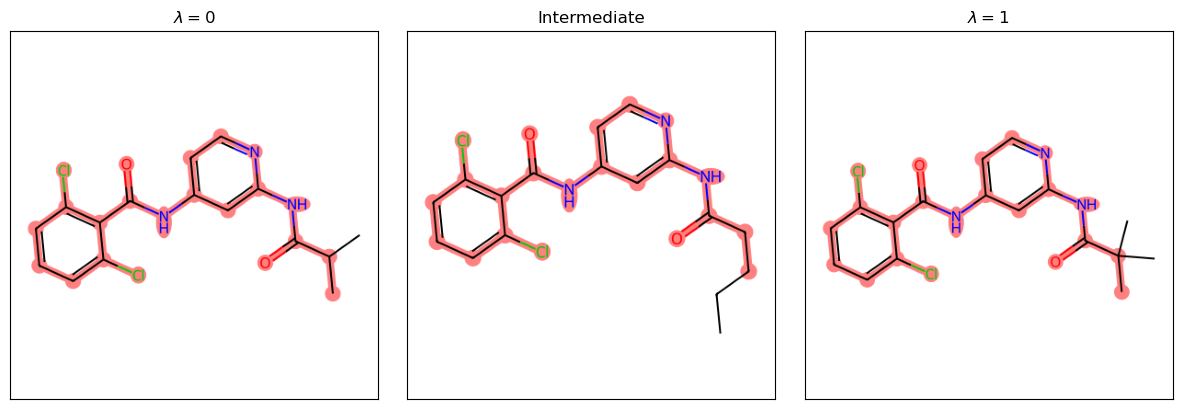

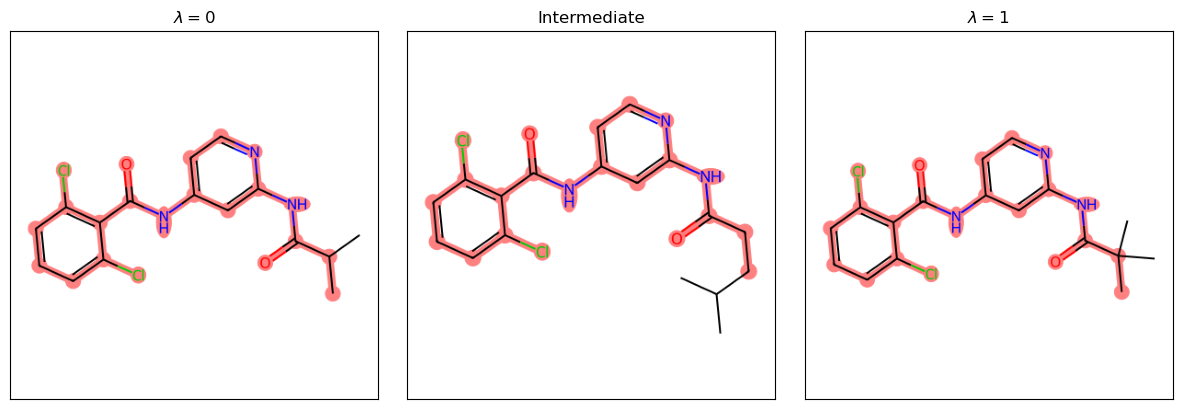

In [84]:
visualise(liga_smiles, ligb_smiles, 'CCC(=O)NC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1')

visualise(liga_smiles, ligb_smiles, 'CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
visualise(liga_smiles, ligb_smiles, 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')

In [99]:
def find_connector_atom(mol, match, rgroup_atoms):
    """
    Find the connector atom in the MCS that was originally bonded to the R-group.
    This atom should have an open valence for reattaching the R-group.

    Args:
    mol (rdkit Mol): The original molecule.
    match (list): List of atoms that are part of the MCS.
    rgroup_atoms (list): List of atoms that are part of the R-group.

    Returns:
    int: The index of the correct connector atom.
    """
    for rgroup_atom in rgroup_atoms:
        atom = mol.GetAtomWithIdx(rgroup_atom)
        for neighbor in atom.GetNeighbors():
            neighbor_idx = neighbor.GetIdx()
            neighbor_atom = mol.GetAtomWithIdx(neighbor_idx)

            # Ensure the neighbor is part of the MCS and has an available bond
            if neighbor_idx in match:
                # Check if this atom has room for a bond
                if neighbor_atom.GetImplicitValence() > 0:
                    print(f"Found connector atom {neighbor_idx} (element {neighbor_atom.GetSymbol()}) with available valence.")
                    return neighbor_idx
                else:
                    print(f"Skipping atom {neighbor_idx} (element {neighbor_atom.GetSymbol()}) due to full valence.")
    return None  # Fallback, but should always find a valid connector atom


def glue_rgroup_to_mcs_with_valence_check(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position, 
    with valence checking to ensure valid bond formation.
    
    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.
    
    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Update property cache to ensure valence is calculated
    mcs_atom = mcs.GetAtomWithIdx(mcs_tag)
    mcs_atom.UpdatePropertyCache()

    # Check if the MCS atom can accept a new bond
    if mcs_atom.GetTotalValence() >= mcs_atom.GetImplicitValence() + mcs_atom.GetExplicitValence():
        raise ValueError(f"Cannot attach R-group to MCS atom {mcs_tag} (element {mcs_atom.GetSymbol()}): Valence exceeded.")
    
    # Print atom details for debugging
    print(f"Gluing R-group at atom {rgroup_tag} (element {rgroup.GetAtomWithIdx(rgroup_tag).GetSymbol()}) to MCS at atom {mcs_tag} (element {mcs_atom.GetSymbol()})")
    
    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)
    
    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)
    
    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, rgroup_tag + mcs.GetNumAtoms(), order=Chem.BondType.SINGLE)
    
    # Get the final molecule
    final_molecule = editable_combined.GetMol()
    
    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)
    
    return final_molecule


def get_compr_paths_with_rgroup_gluing_and_tags(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    """
    Obtain multiple paths/chemical paths from starting_smile to target_smile, extract R-groups,
    glue them back onto the MCS using tagged positions, and print the resulting molecules.
    
    Parameters:
    starting_smile (string): SMILES string of the starting molecule.
    target_smile (string): SMILES string of the target molecule.
    num_tries (int): Number of path attempts.
    num_random_samples (int): Number of random samples to consider.
    collect_bidirectional (bool): If True, also form paths from target_smile to starting_smile.
    fp_type (string): Type of fingerprint.
    
    Returns:
    list: Unique reconstructed molecules (SMILES strings).
    """
    # Obtain paths (This uses your previous `get_compr_paths` function)
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type)
    print(smiles_paths_dir1, smiles_paths_dir2)
    
    # Combine the two lists of paths
    combined_paths = smiles_paths_dir1 + smiles_paths_dir2
    
    # Remove duplicates
    unique_paths = list(set(tuple(path) for path in combined_paths))
    
    # Find the MCS and extract R-groups along with the tagged positions and match arrays
    mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_tagged_rgroups(starting_smile, target_smile)
    
    # Find the correct attachment points in the MCS
    attachment_point_a = find_attachment_point(Chem.MolFromSmiles(starting_smile), match_a, list(map_a.keys()))
    attachment_point_b = find_attachment_point(Chem.MolFromSmiles(target_smile), match_b, list(map_b.keys()))
    
    if attachment_point_a is None or attachment_point_b is None:
        print("Error: Could not find valid attachment points in the MCS.")
        return None
    
    # Reconstructed molecules
    reconstructed_molecules = []
    
    print("Gluing R-groups back onto the MCS at the correct positions:")
    
    # Attach R-group 1 to the correct MCS atom
    rgroup_1_idx = next(iter(map_a.keys()))  # Use the first key in map_a
    mol_with_rgroup_1 = glue_rgroup_to_mcs_with_valence_check(mcs, rgroup_1, map_a[rgroup_1_idx], attachment_point_a)
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_1))
    
    # Attach R-group 2 to the correct MCS atom
    rgroup_2_idx = next(iter(map_b.keys()))  # Use the first key in map_b
    mol_with_rgroup_2 = glue_rgroup_to_mcs_with_valence_check(mcs, rgroup_2, map_b[rgroup_2_idx], attachment_point_b)
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_2))
    
    # Print the reconstructed molecules
    for idx, molecule in enumerate(reconstructed_molecules):
        print(f"Reconstructed Molecule {idx+1}: {molecule}")
    
    return reconstructed_molecules


In [100]:
get_compr_paths_with_rgroup_gluing_and_tags(liga_smiles, ligb_smiles, num_tries, num_random_samples, collect_bidirectional, fp_type)

[['O=C(NC1=CC(NC(=O)C2=C(Cl)C=CC=C2Cl)=CC=N1)C3=CC=CC=C3', 'O=C(NC1=CCNC(=O)C2=C(Cl)C=CC=C2Cl)CC=N1', 'O=CNC=CCNCCCl', 'O=CC=CCNCCCl', 'O=C(C=CCNCCCl)C1=CC=CC=C1', 'O=C(CCCNCCCl)C1=CC=CC=C1', 'O=C(CCCNCCCl)C1=CC=CC=C1', 'O=C(CCCNCCCl)C1=CC=CC=C1', 'O=C(CCCNCNCCl)C1=CC=CC=C1', 'O=C(CCCNCNCCl)C1=CC=CC=C1', 'O=C(CCCNCNC(=O)C#CCl)C1=CC=CC=C1', 'O1C(C)(C)C1(NCNC(=O)C#CCl)C2=CC=CC=C2', 'OC(C)(C)C(NCNC(=O)C#CCl)=CPC1=CC=CC=C1', 'OC(C)(C)C(NCNC(=O)C#CCl)=CPC1=CC=CC=C1', 'OC(C)(C)C(NCNC(=O)C#CCl)=CPCCl', 'CC(C)(C)C(NCNC(=O)C#CCl)=CPCCl', 'CC(C)(C)C(NCNC(=O)C#CCl)=CPCCl', 'CC(C)(C)C(NCNC(=O)C#CCl)=CPCCl', 'CC(C)(C)C(NCNC(=O)C#CCl)=CCl', 'CC(C)(C)C(NCNC(=O)C=C(Cl)C=CC1)=C1Cl', 'CC(C)(C)C(NCNC(=O)C1=C(Cl)C=CC)=C1Cl', 'CC(C)(C)C(NCNC(=O)C1=C(Cl)C=CC)=C1Cl', 'CC(C)(C)C(NCNC(=O)C1=C(Cl)C=CC)=C1Cl', 'CC(C)(C)C(NCNC(=O)C1=C(Cl)C=CC)=C1Cl', 'CC(C)(C)C(NC(N)C(=O)C1=CCl)=C=CC=C1Cl', 'CC(C)(C)C(NC(N)C(=O)C1=CCl)C=CC=C1Cl', 'CC(C)(C)C(CN)C(N)C(=O)C1=C(Cl)C=CC=C1Cl', 'CC(C)(C)C(CN)C(NC(=O)C1=C(Cl)C=CC=C1Cl)C

ValueError: Cannot attach R-group to MCS atom 1 (element O): Valence exceeded.

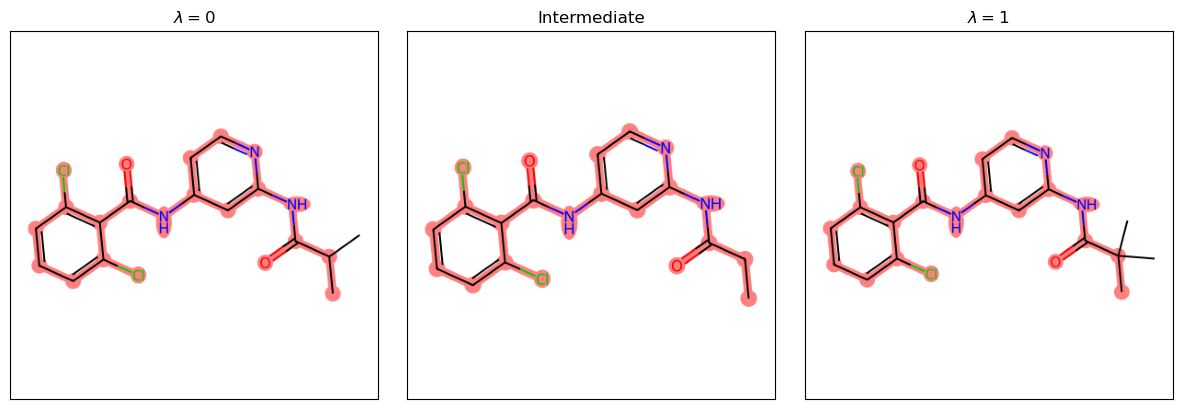

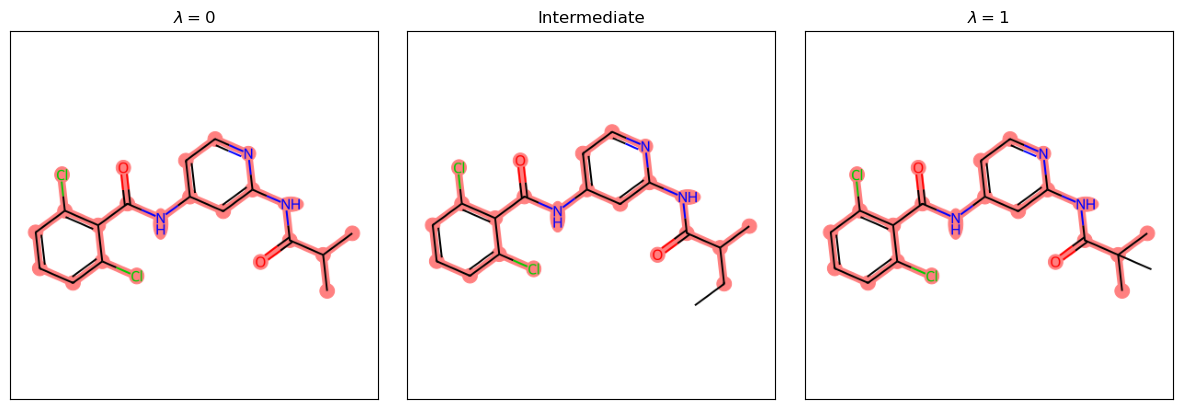

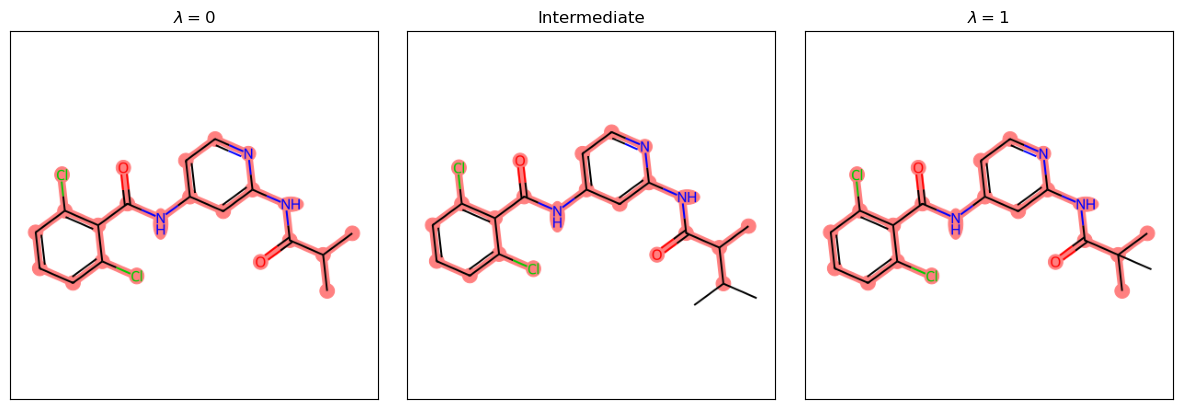

In [87]:
visualise(liga_smiles, ligb_smiles, 'CCC(=O)NC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1')

visualise(liga_smiles, ligb_smiles, 'CCC(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
visualise(liga_smiles, ligb_smiles, 'CC(C)C(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')

In [91]:
def find_mcs_and_expand_with_connector(smiles_1, smiles_2):
    """
    Find the Maximum Common Substructure (MCS), expand it to include the connecting atom
    to the R-group, and return the expanded MCS and the unique R-groups.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (Expanded MCS (rdkit Mol), R-groups from mol1, R-groups from mol2, mapped positions in mol1, mapped positions in mol2, match_a, match_b)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Expand MCS to include the connecting atom
    connector_a = find_connector_atom(mol_a, match_a, atoms_a)
    connector_b = find_connector_atom(mol_b, match_b, atoms_b)
    
    # Add the connector atom to the match (expanding the MCS)
    expanded_match_a = list(match_a) + [connector_a]
    expanded_match_b = list(match_b) + [connector_b]
    
    # Create submolecules for the R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)

    # Map original atom indices to submolecule atom indices
    original_to_sub_a = {original: idx for idx, original in enumerate(atoms_a)}
    original_to_sub_b = {original: idx for idx, original in enumerate(atoms_b)}

    return template, rgroup_a, rgroup_b, original_to_sub_a, original_to_sub_b, expanded_match_a, expanded_match_b


def find_connector_atom(mol, match, rgroup_atoms):
    """
    Find the connector atom, which is part of the MCS but directly connected to the R-group.
    
    Args:
    mol (rdkit Mol): The original molecule.
    match (list): List of atoms that are part of the MCS.
    rgroup_atoms (list): List of atoms that are part of the R-group.
    
    Returns:
    int: The index of the connector atom.
    """
    for rgroup_atom in rgroup_atoms:
        atom = mol.GetAtomWithIdx(rgroup_atom)
        for neighbor in atom.GetNeighbors():
            neighbor_idx = neighbor.GetIdx()
            if neighbor_idx in match:
                return neighbor_idx
    return None  # Should always find a connector atom

def get_compr_paths_with_expanded_mcs_gluing(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    """
    Obtain multiple paths/chemical paths from starting_smile to target_smile, extract R-groups,
    glue them back onto the expanded MCS using the connector atom, and print the resulting molecules.
    
    Parameters:
    starting_smile (string): SMILES string of the starting molecule.
    target_smile (string): SMILES string of the target molecule.
    num_tries (int): Number of path attempts.
    num_random_samples (int): Number of random samples to consider.
    collect_bidirectional (bool): If True, also form paths from target_smile to starting_smile.
    fp_type (string): Type of fingerprint.
    
    Returns:
    list: Unique reconstructed molecules (SMILES strings).
    """
    # Obtain paths (This uses your previous `get_compr_paths` function)
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type)
    print(smiles_paths_dir1, smiles_paths_dir2)
    
    # Combine the two lists of paths
    combined_paths = smiles_paths_dir1 + smiles_paths_dir2
    
    # Remove duplicates
    unique_paths = list(set(tuple(path) for path in combined_paths))
    
    # Find the expanded MCS and extract R-groups along with the connector atoms
    mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_expand_with_connector(starting_smile, target_smile)
    
    # Reconstructed molecules
    reconstructed_molecules = []
    
    print("Gluing R-groups back onto the expanded MCS at the correct positions:")
    
    # Attach R-group 1 to the expanded MCS
    rgroup_1_idx = next(iter(map_a.keys()))  # Use the first key in map_a
    mol_with_rgroup_1 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_1, map_a[rgroup_1_idx], match_a[-1])  # Use connector atom
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_1))
    
    # Attach R-group 2 to the expanded MCS
    rgroup_2_idx = next(iter(map_b.keys()))  # Use the first key in map_b
    mol_with_rgroup_2 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_2, map_b[rgroup_2_idx], match_b[-1])  # Use connector atom
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_2))
    
    # Print the reconstructed molecules
    for idx, molecule in enumerate(reconstructed_molecules):
        print(f"Reconstructed Molecule {idx+1}: {molecule}")
    
    return reconstructed_molecules


In [92]:
find_mcs_and_expand_with_connector(liga_smiles, ligb_smiles)

get_compr_paths_with_rgroup_gluing_and_tags(liga_smiles, ligb_smiles, num_tries, num_random_samples, collect_bidirectional, fp_type)

this is the smiles of the mcs: O=CNC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1
Gluing R-groups back onto the MCS at the correct positions:
Gluing R-group at atom 0 (element C) to MCS at atom 1 (element O)


[16:08:38] Explicit valence for atom # 1 O, 3, is greater than permitted


AtomValenceException: Explicit valence for atom # 1 O, 3, is greater than permitted

In [105]:
def find_connector_atom(mol, match, rgroup_atoms):
    """
    Find the connector atom, which is part of the MCS but was originally bonded to the R-group.
    Ignore current valence status for now since we are reattaching the R-group.

    Args:
    mol (rdkit Mol): The original molecule.
    match (list): List of atoms that are part of the MCS.
    rgroup_atoms (list): List of atoms that are part of the R-group.

    Returns:
    int: The index of the connector atom in the MCS.
    """
    for rgroup_atom in rgroup_atoms:
        atom = mol.GetAtomWithIdx(rgroup_atom)
        for neighbor in atom.GetNeighbors():
            neighbor_idx = neighbor.GetIdx()

            # Ensure the neighbor is part of the MCS
            if neighbor_idx in match:
                print(f"Found connector atom {neighbor_idx} (element {mol.GetAtomWithIdx(neighbor_idx).GetSymbol()})")
                return neighbor_idx

    raise ValueError("No valid connector atom found in the MCS.")



# Example usage after finding the MCS and connector atom
mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_expand_with_connector(liga_smiles, ligb_smiles)
connector_atom_idx = find_connector_atom(Chem.MolFromSmiles(liga_smiles), match_a, list(map_a.keys()))

# Visualize the MCS with the connector atom highlighted
visualize_mcs_with_connector(mcs, connector_atom_idx)


Found connector atom 1 (element C)
Found connector atom 4 (element C)
Found connector atom 1 (element C)


In [106]:
from rdkit.Chem import rdFMCS

def find_mcs_with_mapping(mol_a, mol_b):
    """
    Find the MCS between two molecules and return the MCS along with atom mappings
    from the original molecules to the MCS.

    Args:
    mol_a (rdkit Mol): The first molecule.
    mol_b (rdkit Mol): The second molecule.

    Returns:
    tuple: MCS molecule, atom mapping from mol_a to MCS, atom mapping from mol_b to MCS.
    """
    mcs_result = rdFMCS.FindMCS([mol_a, mol_b], 
                                atomCompare=rdFMCS.AtomCompare.CompareElements,
                                bondCompare=rdFMCS.BondCompare.CompareAny,
                                matchValences=False,
                                ringMatchesRingOnly=True,
                                completeRingsOnly=True,
                                matchChiralTag=False,
                                timeout=2)
    
    mcs_smarts = mcs_result.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)

    # Get the mapping from the original molecules to the MCS
    mapping_a = mol_a.GetSubstructMatch(mcs_mol)
    mapping_b = mol_b.GetSubstructMatch(mcs_mol)
    
    return mcs_mol, mapping_a, mapping_b

def find_connector_atom_with_mapping(mol, rgroup_atoms, mapping):
    """
    Identify the correct connector atom in the MCS by mapping the original atom that was
    connected to the R-group in the full molecule.

    Args:
    mol (rdkit Mol): The original molecule.
    rgroup_atoms (list): List of atoms that are part of the R-group in the full molecule.
    mapping (list): Mapping of atom indices from the full molecule to the MCS.

    Returns:
    int: The index of the connector atom in the MCS.
    """
    for rgroup_atom in rgroup_atoms:
        atom = mol.GetAtomWithIdx(rgroup_atom)
        for neighbor in atom.GetNeighbors():
            neighbor_idx = neighbor.GetIdx()

            # If the neighbor is part of the MCS (i.e., mapped), return the corresponding MCS atom
            if neighbor_idx in mapping:
                mcs_idx = mapping.index(neighbor_idx)  # Find the corresponding MCS atom
                print(f"Found connector atom {mcs_idx} in the MCS (original atom {neighbor_idx})")
                return mcs_idx

    raise ValueError("No valid connector atom found.")


In [107]:
mol_a = Chem.MolFromSmiles(liga_smiles)
mol_b = Chem.MolFromSmiles(ligb_smiles)

# Find the MCS and atom mappings
mcs, mapping_a, mapping_b = find_mcs_with_mapping(mol_a, mol_b)

# Find the connector atom in the MCS
connector_atom_idx = find_connector_atom_with_mapping(mol_a, list(map_a.keys()), mapping_a)

# Visualize the MCS with the connector atom highlighted
visualize_mcs_with_connector(mcs, connector_atom_idx)


Found connector atom 0 in the MCS (original atom 1)


In [119]:
def glue_rgroup_to_mcs(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.

    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.

    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Print atom details for debugging
    print(f"Attaching R-group at atom {rgroup_tag} (element {rgroup.GetAtomWithIdx(rgroup_tag).GetSymbol()}) to MCS at atom {mcs_tag} (element {mcs.GetAtomWithIdx(mcs_tag).GetSymbol()})")

    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)

    # Adjust the R-group atom index to account for the MCS atoms
    adjusted_rgroup_tag = rgroup_tag + mcs.GetNumAtoms()

    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)

    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, adjusted_rgroup_tag, order=Chem.BondType.SINGLE)

    # Get the final molecule
    final_molecule = editable_combined.GetMol()

    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)

    return final_molecule



def attach_rgroups_to_mcs(mcs, rgroup_1, rgroup_2, connector_atom_idx_a, connector_atom_idx_b, rgroup_atom_a, rgroup_atom_b):
    """
    Attach R-group 1 and R-group 2 to the MCS at the respective connector atoms.

    Args:
    mcs (rdkit Mol): The MCS molecule.
    rgroup_1 (rdkit Mol): The first R-group molecule.
    rgroup_2 (rdkit Mol): The second R-group molecule.
    connector_atom_idx_a (int): The index of the connector atom in MCS for R-group 1.
    connector_atom_idx_b (int): The index of the connector atom in MCS for R-group 2.
    rgroup_atom_a (int): The index of the attachment point in R-group 1.
    rgroup_atom_b (int): The index of the attachment point in R-group 2.

    Returns:
    list: List of the final reconstructed molecules as SMILES strings.
    """
    # Attach R-group 1 to the MCS
    mol_with_rgroup_1 = glue_rgroup_to_mcs(mcs, rgroup_1, rgroup_atom_a, connector_atom_idx_a)
    
    # Attach R-group 2 to the MCS
    mol_with_rgroup_2 = glue_rgroup_to_mcs(mcs, rgroup_2, rgroup_atom_b, connector_atom_idx_b)

    # Convert to SMILES for easy comparison
    smiles_1 = Chem.MolToSmiles(mol_with_rgroup_1)
    smiles_2 = Chem.MolToSmiles(mol_with_rgroup_2)

    return [smiles_1, smiles_2]


In [120]:
# Example molecules (using SMILES)
mol_a = Chem.MolFromSmiles(liga_smiles)
mol_b = Chem.MolFromSmiles(ligb_smiles)

# Find the MCS and atom mappings
mcs, mapping_a, mapping_b = find_mcs_with_mapping(mol_a, mol_b)

# Find the connector atoms in the MCS
connector_atom_idx_a = find_connector_atom_with_mapping(mol_a, list(map_a.keys()), mapping_a)
connector_atom_idx_b = find_connector_atom_with_mapping(mol_b, list(map_b.keys()), mapping_b)

# Indices of the atoms in the R-groups to attach (replace these with the actual indices)
rgroup_atom_a = list(map_a.keys())[0]  # Example atom index for R-group 1
rgroup_atom_b = list(map_b.keys())[0]  # Example atom index for R-group 2

# Attach the R-groups to the MCS and get the final molecules
final_smiles = attach_rgroups_to_mcs(mcs, rgroup_1, rgroup_2, connector_atom_idx_a, connector_atom_idx_b, rgroup_atom_a, rgroup_atom_b)

# Print the final reconstructed molecules
print(f"Reconstructed Molecule 1: {final_smiles[0]}")
print(f"Reconstructed Molecule 2: {final_smiles[1]}")


Found connector atom 0 in the MCS (original atom 1)
Found connector atom 0 in the MCS (original atom 4)


[16:40:58] 

****
Range Error
idx
Violation occurred on line 209 in file /home/conda/feedstock_root/build_artifacts/rdkit-meta_1727191688849/work/Code/GraphMol/ROMol.cpp
Failed Expression: 20 < 8
----------
Stacktrace:
 0# Invar::Invariant::toString[abi:cxx11]() const in /mnt/scratch_dir/jiskootd/conda/envs/intermediates/lib/python3.12/site-packages/rdkit/../../../libRDKitRDGeneral.so.1
 1# Invar::operator<<(std::ostream&, Invar::Invariant const&) in /mnt/scratch_dir/jiskootd/conda/envs/intermediates/lib/python3.12/site-packages/rdkit/../../../libRDKitRDGeneral.so.1
 2# RDKit::ROMol::getAtomWithIdx(unsigned int) in /mnt/scratch_dir/jiskootd/conda/envs/intermediates/lib/python3.12/site-packages/rdkit/Chem/../../../../libRDKitGraphMol.so.1
 3# 0x00007F7185E89274 in /mnt/scratch_dir/jiskootd/conda/envs/intermediates/lib/python3.12/site-packages/rdkit/Chem/rdchem.so
 4# boost::python::objects::function::call(_object*, _object*) const in /mnt/scratch_dir/jiskootd/conda/envs/intermediates/li

RuntimeError: Range Error
	idx
	Violation occurred on line 209 in file Code/GraphMol/ROMol.cpp
	Failed Expression: 20 < 8
	RDKIT: 2024.03.6
	BOOST: 
